In [5]:
%load_ext autoreload
%autoreload 2
from sklearn.decomposition import NMF
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve
from typing import List
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from project_1.helpers import lemmatize_corpus, stem_corpus, resample_and_merge
from sklearn.preprocessing import FunctionTransformer, normalize
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn import FunctionSampler
from nltk.corpus import stopwords
from typing import Dict
from umap.umap_ import UMAP
import umap.plot
import warnings
from typing import Optional
from sklearn.utils import parallel_backend

nltk.download('punkt')
nltk.download('stopwords')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to /home/niklasz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/niklasz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
### Configuration ###
file_name = 'data.csv'
seed = 42
np.random.seed(seed)
random.seed(seed)

# We suppress various convergence warnings to keep the submission code more readable.
warnings.filterwarnings("ignore")
def filter_parallel_warnings(func):
    with parallel_backend("multiprocessing"):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            return func()

In [7]:
df = pd.read_csv(file_name)
# df.head()

In [8]:
### Clean-ups ###
# Fix "%22forest%20fire%22" class label
df['leaf_label'] = df.apply(lambda row: row['leaf_label'].strip('%22').replace('%20', ' '), axis=1)

# Question 1

## Samples and Features in dataset

In [9]:
no_samples, no_features = df.shape
print(f'The dataset has {no_samples} samples and {no_features} features')

The dataset has 3150 samples and 8 features


## Histograms of Corpus

Text(0.5, 1.0, "Alpha-numeric character counts in 'full_text' with 100 bins")

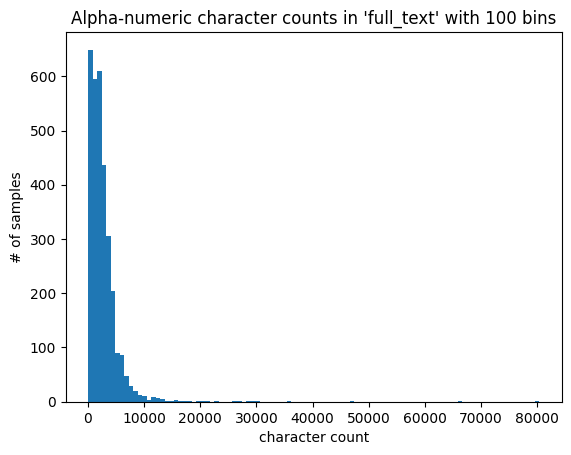

In [10]:
### Histogram - alphanumeric ###
name = 'full_text'


def count_alphanumeric(row):
    alphanumeric_str = re.sub(r'[^a-zA-Z0-9]', '', row[name])
    row['alphanumeric_count'] = len(alphanumeric_str)
    return row


df_alphanumeric = df.apply(count_alphanumeric, axis=1)
bin_count = 100
plt.hist(df_alphanumeric['alphanumeric_count'], bins=bin_count)
plt.xlabel('character count')
plt.ylabel('# of samples')
plt.title(f"Alpha-numeric character counts in '{name}' with {bin_count} bins")

Text(0.5, 1.0, "Class distribution of 'leaf_label'")

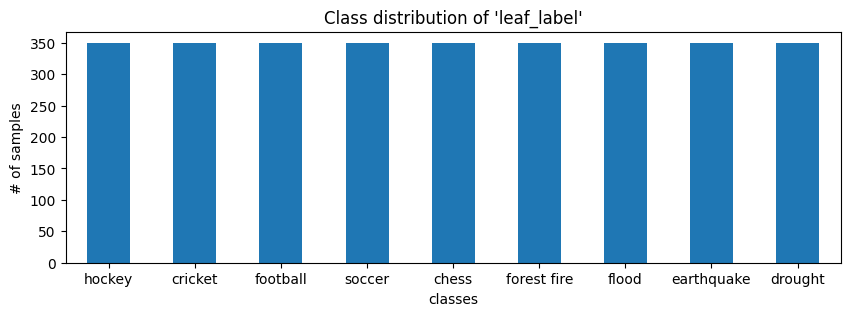

In [11]:
### Histogram - leaf_label ###
name = 'leaf_label'
leaf_label_counts = df[name].value_counts()

plt.figure(figsize=(10, 3))
leaf_label_counts.plot.bar(x='lab', y='val', rot=0)
plt.xlabel('classes')
plt.ylabel('# of samples')
plt.title(f"Class distribution of '{name}'")

Text(0.5, 1.0, "Class distribution of 'root_label'")

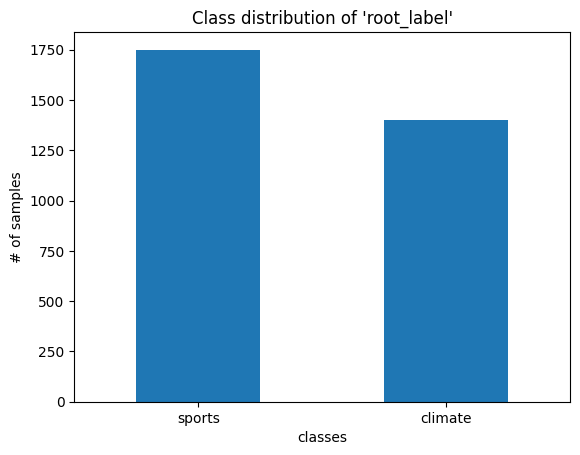

In [12]:
### Histogram - root_label ###
name = 'root_label'
root_label_counts = df[name].value_counts()

root_label_counts.plot.bar(x='lab', y='val', rot=0)
plt.xlabel('classes')
plt.ylabel('# of samples')
plt.title(f"Class distribution of '{name}'")

## Qualitative Analysis
1. As alphanumeric characters likely make up the bulk of each document, this histogram gives us a sense of how the size of documents are distributed. We can see that the vast majority is < 10000 characters with a few large outliers in the 10000-80000 range.
2. There are 9 classes among the leaf labels and they are uniformly distributed among the samples, which is convenient as this means we may not need to resample or augment the data to train a classifier.
3. There are 2 classes among the root labels and that the distribution is uneven (~56% sports, ~44% climate). This means we may need to augment climate samples or drop the least valuable sports samples. Alternatively, any classifier needs to be > 56% accurate to be better to be meaningful.

# Question 2

In [13]:
### Sample counts ###
train, test = train_test_split(df[["full_text", "summary", "root_label", "leaf_label"]], test_size=0.2,
                               random_state=seed)
print(f'There are {len(train)} train and {len(test)} test samples')

There are 2520 train and 630 test samples


# Question 3

## TF-IDF Generation

In [14]:
### Feature Extraction ###
# NOTE: the lemmatisation and stemming code is in a separate file because python's pickle module will only work when they are considered "modules".
# Pickle is needed in Q8 and later questions to support parallelisation of grid search.
train_lemmatized = lemmatize_corpus(train['full_text'])
test_lemmatized = lemmatize_corpus(test['full_text'])

vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
train_tf_idf = vectorizer.fit_transform(train_lemmatized)
names = vectorizer.get_feature_names_out()
test_tf_idf = vectorizer.transform(test_lemmatized)

## What are the pros and cons of lemmatisation versus stemming?
Stemming algorithms use heuristics that remove prefixes and suffixes from words to simplify them down to a base form. Lemmatisation performs a part-of-speech (POS) tagging and morphological analysis to reduce words down their base form. Both have the purpose of simplifying a text for downstream tasks.

Stemming is easiest to implement for a new language as it does not require a dictionary of words and POS tagger that understands the language's grammar. It is also computationally cheaper than lemmatisation. The resulting dictionary of words is smaller, but less precise.

Lemmatisaton requires the aforementioned additional structures for a language and is computationally more expensive to run on a corpus. The resulting dictionary is larger and more precise.

Here is a comparison of the NLTK Porter Stemmer and WordNet Lemmatizer:

- Input: "I attained universal knowledge of the universe at university."
- Porter Stemmer: "i attain univers knowledg of the univers at univers ."
- WordNetLemmatizer: "I attain universal knowledge of the universe at university ."

## How does varying min_df change the TF-IDF matrix?
The minimum document frequency of a word specifies in at least how many documents a word must appear to be incuded in the TF-IDF frequency matrix. Accordingly, a lower `min_df` results in rarer words to be included yielding a larger dictionary (more columns) in the matrix. A higher `min_df` will only consider more common words, yielding a smaller dictionary (fewer columns) in the matrix.

## Should I remove stopwords, punctuations, numbers before or after lemmatizing?
This depends on the nature of the corpus and the underlying POS-tagger used for the lemmatizer. In theory, none of the above are needed for lemmatization, but the POS-tagger may have more trouble correctly applying the right tag if the sentences are simplified too much. Stopwords tend to very common grammatical particles, so they can strongly affect the POS-tagger. Punctuation is useful to POS as it can separate sentences more easily. Numbers are probably the most expendable and can likely be dropped beforehand without much consequence.

## Shape of Processed Matrices


In [15]:
print(f'Shape of train TF-IDF matrix: {train_tf_idf.shape}')
print(f'Shape of test TF-IDF matrix: {test_tf_idf.shape}')

Shape of train TF-IDF matrix: (2520, 14218)
Shape of test TF-IDF matrix: (630, 14218)


# Question 4

In [16]:
# Latent Semantic Indexing
def reduce_dim_lsi(k: int):
    lsi = TruncatedSVD(n_components=k, random_state=seed)
    reduced_train_data = lsi.fit_transform(train_tf_idf)
    reduced_test_data = lsi.transform(test_tf_idf)
    return lsi, reduced_train_data, reduced_test_data


# Non-negative Matrix Factorization
def reduce_dim_nmf(k: int):
    nmf = NMF(n_components=k, init='random', random_state=seed)
    reduced_train_data = nmf.fit_transform(train_tf_idf)  # performing NMF on the tfidf train matrix
    reduced_test_data = nmf.transform(test_tf_idf)  # performing NMF on the tfidf test matrix
    return nmf, reduced_train_data, reduced_test_data


## LSI Explained variance ratios

In [17]:
variance_ratios = []
ranges = [1, 10, 50, 100, 200, 500, 1000, 2000]
l, _, _ = reduce_dim_lsi(2000)
for r in ranges:
    variance_ratios.append(l.explained_variance_ratio_[:r])

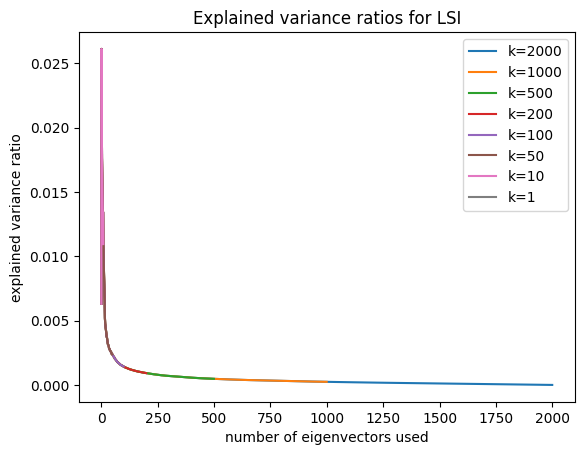

In [18]:
# Plot explained variance ratios
for r in reversed(variance_ratios):
    k = len(r)
    plt.plot(r, label=f'k={k}')
plt.legend()
plt.xlabel('number of eigenvectors used')
plt.ylabel('explained variance ratio')
plt.title('Explained variance ratios for LSI')
plt.show()

#### What does the explained variance ratio plot look like? What does the plot’s concavity suggest?
This plot depicts how much each eigenvector can explain the variance of our data. As we order by eigenvalue (or rather, the derived variance ratio), we have our most significant variances on the left and least significant on the right. What the shape of the plot tells us is that there is a diminishing relevance with each additional eigenvector. It also shows roughly how many eigenvectors we need to characterise the data. Based on the plot,this appears to be somewhere in $50 \leq k \leq 100$.

## Reconstruction MSE


In [19]:
lsi_handler, train_lsi, test_lsi = reduce_dim_lsi(k=50)
nmf_handler, train_nmf, test_nmf = reduce_dim_nmf(k=50)

In [20]:
## Losses
# LSI
VT = lsi_handler.components_
lsi_train_loss = np.linalg.norm(train_tf_idf - np.matmul(train_lsi, VT)) ** 2
lsi_test_loss = np.linalg.norm(test_tf_idf - np.matmul(test_lsi, VT)) ** 2
print(f'LSI loss - train: {lsi_train_loss}, test: {lsi_test_loss}')

# NMF
H = nmf_handler.components_
nmf_train_loss = np.linalg.norm(train_tf_idf - np.matmul(train_nmf, H)) ** 2
nmf_test_loss = np.linalg.norm(test_tf_idf - np.matmul(test_nmf, H)) ** 2
print(f'NMF loss - train: {nmf_train_loss}, test: {nmf_test_loss}')


LSI loss - train: 1675.5712101468528, test: 445.946249185874
NMF loss - train: 1701.466046094306, test: 451.339568585048


#### Which one is larger and why?
We can see from the above that the reconstruction error is slightly larger for NMF method. One possible reason for this could be that NMF's constraint that $H,W \geq 0$, whereas LSI's $V$ component matrix is not limited to this. As a result, LSI should have an easier time fitting the dataset.

# Question 5

## Linear SVMs


In [21]:
# SVMs
gammas = [0.0001, 1000, 100000]  # weights how much to consider classification loss vs. regularisation loss
binary_classes = list(root_label_counts.keys())
pos_label = binary_classes[0]


def print_metrics(true_y: np.ndarray, pred_y: np.ndarray, pos_label: Optional[str] = None,
                  average: Optional[str] = None):
    print(f'Accuracy: {accuracy_score(true_y, pred_y, normalize=True)}')
    print(f'Recall: {recall_score(true_y, pred_y, pos_label=pos_label, average=average)}')
    print(f'Precision: {precision_score(true_y, pred_y, pos_label=pos_label, average=average)}')
    print(f'F-1 score: {f1_score(true_y, pred_y, pos_label=pos_label, average=average)}')


def plot_confusion_matrix(estimator, X: np.ndarray, true_y: np.ndarray, classes: List[str], title: str):
    disp = ConfusionMatrixDisplay.from_estimator(
        estimator,
        X,
        true_y,
        display_labels=classes,  # for some reason it gets the labels the wrong way around?
        cmap=plt.cm.Blues,
    )
    disp.ax_.set_title(title)
    plt.show()


def plot_roc(estimator, true_y: np.ndarray, pos_label: str, title: str):
    class_1_probs = estimator.decision_function(test_lsi)
    false_pos_rate, true_pos_rate, thresholds = roc_curve(true_y, class_1_probs, pos_label=pos_label)
    plt.figure()
    plt.plot(false_pos_rate, true_pos_rate)
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()


==For gamma=0.0001==
Accuracy: 0.5825396825396826
Recall: 1.0
Precision: 0.5825396825396826
F-1 score: 0.7362086258776329
Coefficient mean magnitude: 0.0034484363074094924


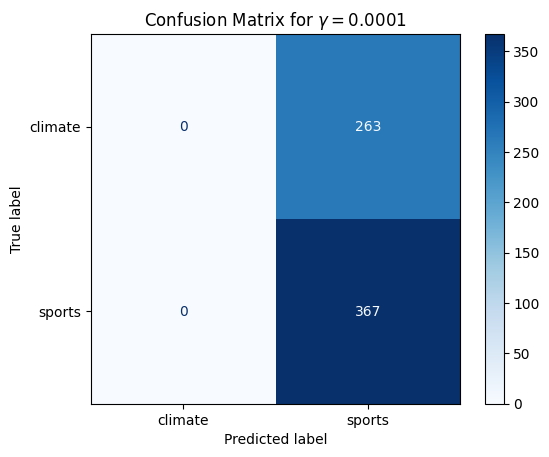

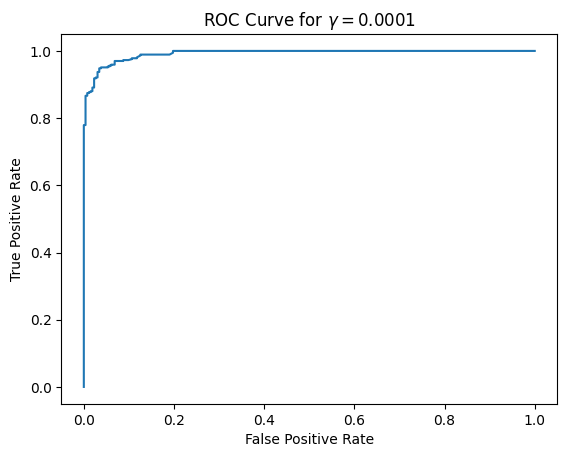


==For gamma=1000==
Accuracy: 0.9619047619047619
Recall: 0.9509536784741145
Precision: 0.9830985915492958
F-1 score: 0.9667590027700832
Coefficient mean magnitude: 3.687205652252722


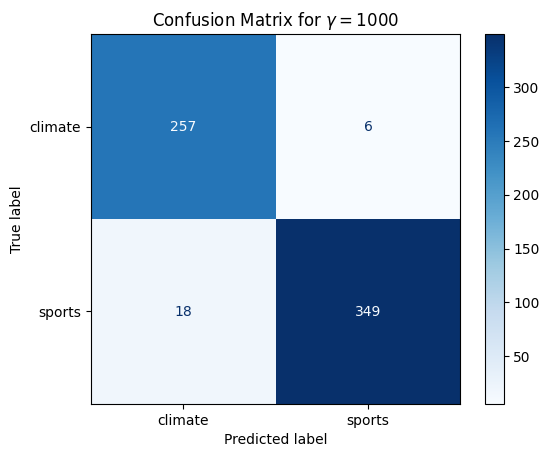

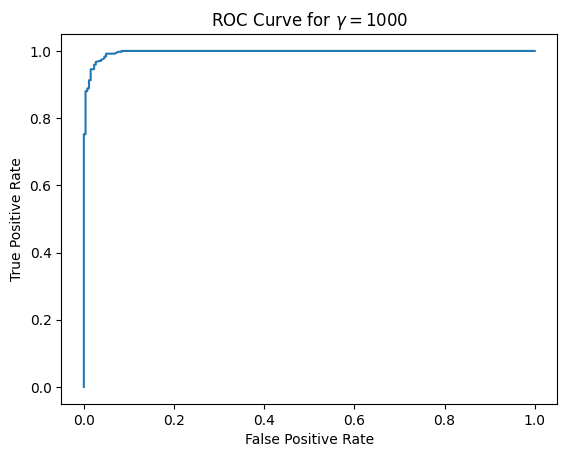


==For gamma=100000==
Accuracy: 0.9603174603174603
Recall: 0.9863760217983651
Precision: 0.9476439790575916
F-1 score: 0.9666221628838451
Coefficient mean magnitude: 3.808356380175704


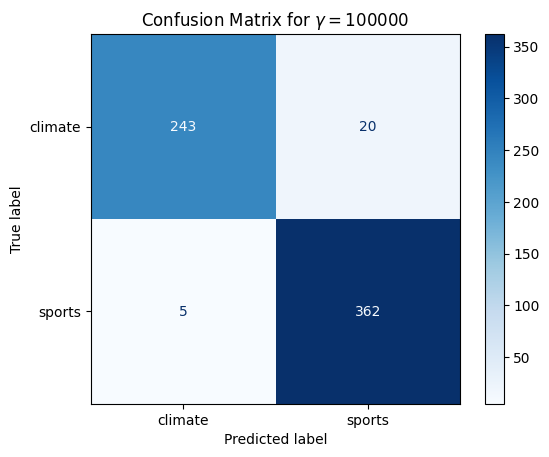

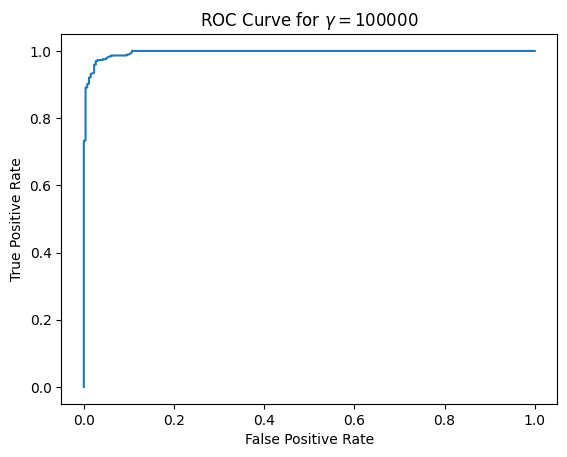

In [22]:
for gamma in gammas:
    print(f'\n==For gamma={gamma}==')
    # Train
    svm = LinearSVC(C=gamma, random_state=seed, max_iter=10000)
    svm.fit(X=train_lsi, y=train.root_label)
    # Predict
    pred_y = svm.predict(test_lsi)
    true_y = test.root_label.values
    # Metrics
    print_metrics(true_y, pred_y, pos_label, average='binary')
    print(f'Coefficient mean magnitude: {abs(svm.coef_).mean()}')
    # for some reason it gets the labels the wrong way around?
    plot_confusion_matrix(svm, test_lsi, true_y, list(reversed(binary_classes)),
                          f'Confusion Matrix for $\gamma = {gamma}$')
    plot_roc(svm, true_y, pos_label, f'ROC Curve for $\gamma = {gamma}$')

#### Which one performs better?

In the above we can see $\gamma = 1000$ hardness SVM has the best accuracy and F-1 score, making it the best overall.

#### What happens for the soft margin SVM? Why is the case?
Regarding the soft-margin ($\gamma = 0.0001$) SVM, the incredibly low weighting of the classification loss causes the optimisation to overprioritise the weight regularisation loss. As a result, the model's weights are too small (0.0034 mean magnitude vs. 3.7326 for other SVMs) and it does not discriminate the input feature vectors well. We can also observe this in the confusion matrix, where the model is biased to predict everything to be of the "sports" class.

#### Does the ROC curve reflect the performance of the soft-margin SVM? Why?
Notably, the ROC curve does not really show this, because we have no False Negatives (FNs) or True Negatives (TNs). As a result, the TPR and FPR look as follows:

$$TPR = \frac{TP}{TP + FN} \approx \frac{TP}{TP}$$
$$FPR = \frac{FP}{FP + TN} \approx \frac{FP}{FP}$$

As we alter the threshold the model's strong bias towards "sports" keeps the TP high and therefore close to 1.

## Best $\gamma$ and cross-validation

In [23]:
# Grid search
hyper_params = {
    'C': 10 ** np.arange(-3, 7, dtype=float)
}
svm = LinearSVC(random_state=seed, max_iter=10000)
def run_train():
    search = GridSearchCV(svm, hyper_params, cv=5, scoring='accuracy', n_jobs=8, verbose=1)
    search_result = search.fit(train_lsi, train.root_label)
    return search, search_result

search, search_result = filter_parallel_warnings(run_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best hyper-parameters: {'C': 10.0}
Accuracy: 0.9634920634920635
Recall: 0.9564032697547684
Precision: 0.9804469273743017
F-1 score: 0.9682758620689655


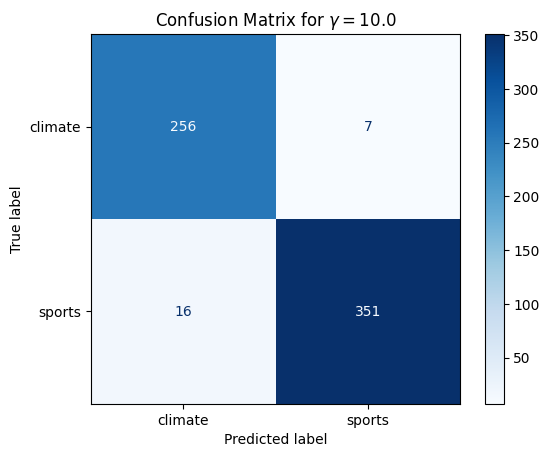

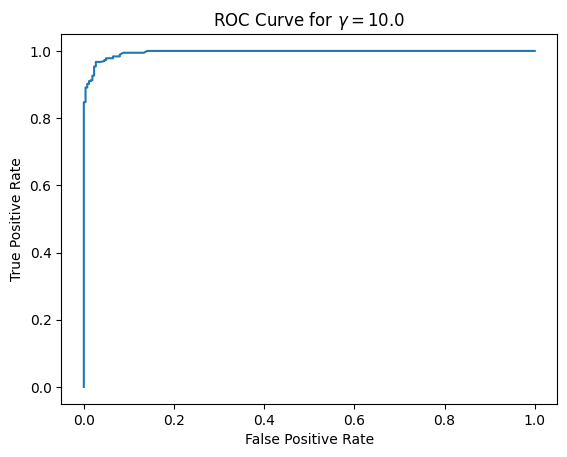

In [24]:
# Plot results
print(f'Best hyper-parameters: {search_result.best_params_}')
gamma = search_result.best_params_['C']
best_svm = search_result.best_estimator_

svm.fit(X=train_lsi, y=train.root_label)
pred_y = svm.predict(test_lsi)
true_y = test.root_label.values
# Metrics
print_metrics(true_y, pred_y, pos_label, average='binary')
# for some reason it gets the labels the wrong way around?
plot_confusion_matrix(svm, test_lsi, true_y, list(reversed(binary_classes)),
                      f'Confusion Matrix for $\gamma = {gamma}$')
plot_roc(svm, true_y, pos_label, f'ROC Curve for $\gamma = {gamma}$')

# Question 6
## Base Logistic Classifier

Accuracy: 0.9650793650793651
Recall: 0.9564032697547684
Precision: 0.9831932773109243
F-1 score: 0.9696132596685083


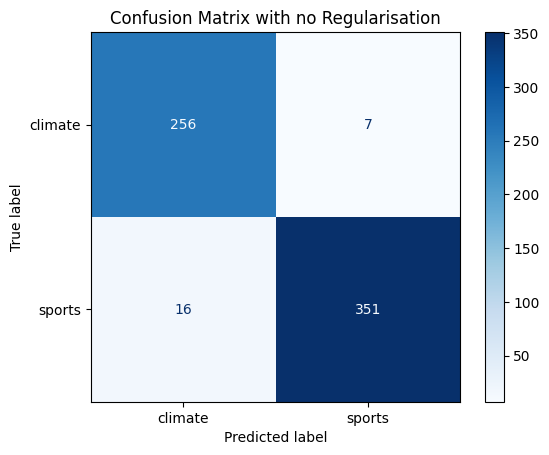

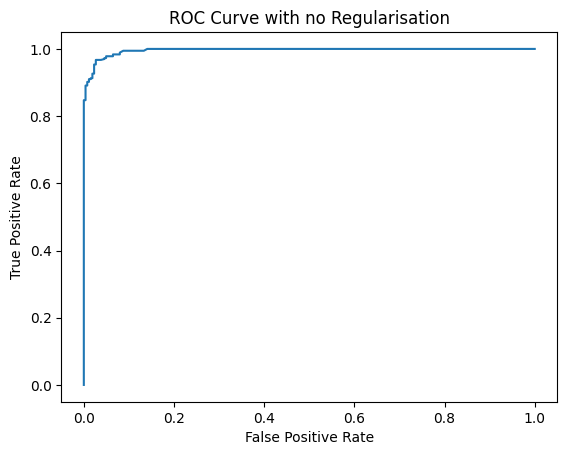

In [25]:
base_logistic = LogisticRegression(penalty=None, random_state=seed, max_iter=10000)
base_logistic.fit(X=train_lsi, y=train.root_label)
pred_y = base_logistic.predict(test_lsi)
true_y = test.root_label.values
# Metrics
print_metrics(true_y, pred_y, pos_label, average='binary')
# for some reason it gets the labels the wrong way around?
plot_confusion_matrix(svm, test_lsi, true_y, list(reversed(binary_classes)),
                      f'Confusion Matrix with no Regularisation')
plot_roc(svm, true_y, pos_label, f'ROC Curve with no Regularisation')

## Logistic + Regularisation

In [26]:
# Tune L1 and L2 regularisations
hyper_params = {
    'C': 10 ** np.arange(-5, 6, dtype=float)
}

def run_train():
    regularisers = [None, 'l1', 'l2']
    search_results = []
    for r in regularisers:
        model = LogisticRegression(penalty=r, random_state=seed, max_iter=10000, solver='saga')
        search = GridSearchCV(model, hyper_params, cv=5, scoring='accuracy', n_jobs=8, verbose=1)
        search_result = search.fit(train_lsi, train.root_label)
        search_results.append(search_result)
    return regularisers, search_results

regularisers, search_results = filter_parallel_warnings(run_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits



Results when using no regulariser
Train accuracy: 0.9615079365079365
Validation accuracy: 0.95
==Test Metrics==
Accuracy: 0.9650793650793651
Recall: 0.9564032697547684
Precision: 0.9831932773109243
F-1 score: 0.9696132596685083


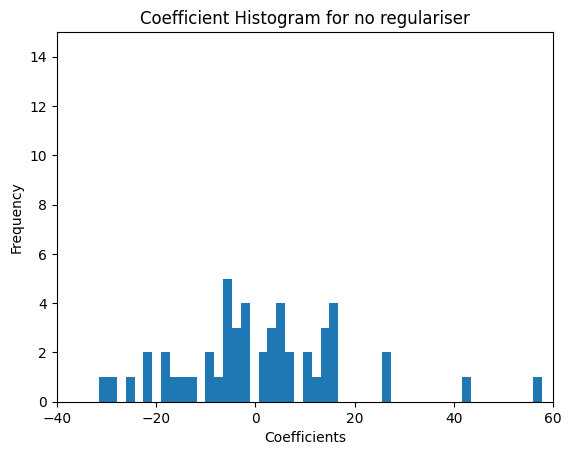


Results when using l1 regulariser
Best hyper-parameters: {'C': 10.0}
Train accuracy: 0.959920634920635
Validation accuracy: 0.9511904761904763
==Test Metrics==
Accuracy: 0.9619047619047619
Recall: 0.9536784741144414
Precision: 0.9803921568627451
F-1 score: 0.9668508287292817


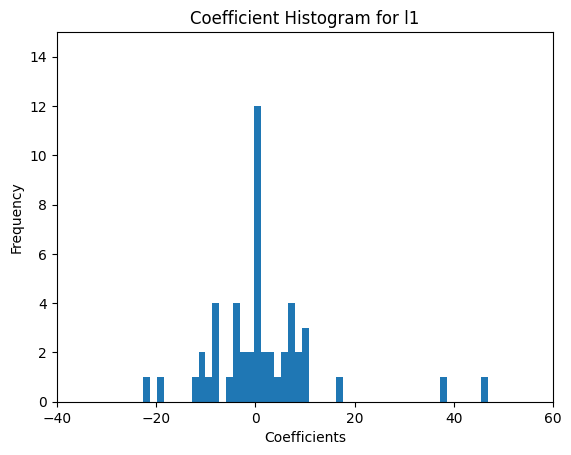


Results when using l2 regulariser
Best hyper-parameters: {'C': 100.0}
Train accuracy: 0.9595238095238096
Validation accuracy: 0.9527777777777778
==Test Metrics==
Accuracy: 0.9634920634920635
Recall: 0.9536784741144414
Precision: 0.9831460674157303
F-1 score: 0.9681881051175657


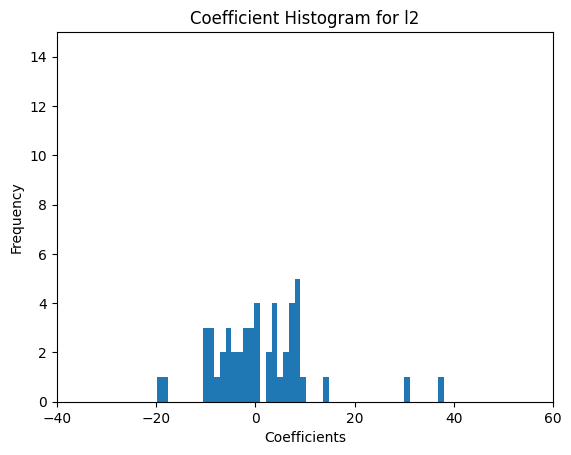

In [27]:
def plot_parameter_histogram(coefficients: np.ndarray, title: str):
    plt.hist(coefficients.squeeze(), bins=50)
    plt.xlim([-40, 60])
    plt.ylim([0, 15])
    plt.xlabel('Coefficients')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()


for name, result in zip(regularisers, search_results):
    gamma = result.best_params_['C']
    best_logistic = result.best_estimator_

    best_logistic.fit(X=train_lsi, y=train.root_label)
    pred_y = best_logistic.predict(test_lsi)
    true_y = test.root_label.values
    # Metrics
    # Using a regulariser
    if name:
        print(f'\nResults when using {name} regulariser')
        print(f'Best hyper-parameters: {result.best_params_}')
        hist_title = f'Coefficient Histogram for {name}'
    # Using no regulariser
    else:
        print(f'\nResults when using no regulariser')
        hist_title = f'Coefficient Histogram for no regulariser'

    train_accuracy = best_logistic.score(train_lsi, train.root_label)
    validation_accuracy = result.best_score_
    print(f'Train accuracy: {train_accuracy}')
    print(f'Validation accuracy: {validation_accuracy}')
    print('==Test Metrics==')
    print_metrics(true_y, pred_y, pos_label, average='binary')
    plot_parameter_histogram(best_logistic.coef_, hist_title)

#### How does the regularization parameter affect the test error?
Comparing the trained models, we can see that the accuracy is largely the same, actually slightly favouring the model without regularisation. In theory, regularisation should mitigate the overfitting of a model during training, which in turn reduces the usual gap between training accuracy and validation and test accuracy. However, in the base logistic model's case, there was no significant gap between these accuracies to begin with, so usage of L1 and L2 regularisation has little effect.

#### How are the learnt coefficients affected?
Histograms showing the coefficients of each model with respective regularisation are shown above. In the non-regularised case, we observe more uniformly distributed coefficients, with higher min-max values. This makes sense as there is no penalisation for weights having a high magnitude. In the L1 case, we can see that most coefficients are clustering at 0, which makes sense as the regularisation $\|\textbf{w}\|$ is best minimised at 0. In the L2 case, we note that weights cluster more near 0 than at 0 exactly. This follows from the $\|\textbf{w}\|^2$ term already minimising weights significantly by squaring them in the $(-1,1)$ range.

#### Why might one be interested in each type of regularization?
For L1 regularisation, the main advantage is dimensionality reduction. By pushing some weight $w_i$ towards 0, it helps identify which corresponding feature ($i$th column in $X$) has no impact on the classification and can therefore safely be dropped. This often helps reduce the number of highly correlated features. With L2 we do not reduce the number of features and usually can obtain a slightly better accuracy as a result. It is also continuously differentiable (as opposed to L1), which makes it easier to compute for gradient-based optimisation methods.

## Logistic vs. SVM
#### What is the difference between their ways to find this boundary?
Logistic regression fits a decision boundary based on the entire dataset that maximises the likelihood of the class, given the data. An SVM fits a decision boundary geometrically and tries to fit one that has the largest distance to the support vectors (i.e datapoints closest to the boundary).

#### Why do their performances differ?
As mentioned earlier, they fit their boundaries with different constraints. Unless the data is perfectly linearly separable, it's possible that they will classify datapoints differently.

#### Is this difference statistically significant?

In [28]:
# Run best logistic model multiple times on different seeds
logistic_model = LogisticRegression(penalty=None, max_iter=10000, solver='saga')
svm_model = LinearSVC(max_iter=10000, C=10)

hyper_params = {
    'random_state': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}
logistic_search = GridSearchCV(logistic_model, hyper_params, scoring='accuracy', n_jobs=8, verbose=0)
svm_search = GridSearchCV(svm_model, hyper_params, scoring='accuracy', n_jobs=8, verbose=0)

logistic_search_result = logistic_search.fit(train_lsi, train.root_label)
svm_search_result = svm_search.fit(train_lsi, train.root_label)

In [29]:
logistic_training_accuracies = logistic_search_result.cv_results_['mean_test_score']
svm_training_accuracies = logistic_search_result.cv_results_['mean_test_score']

print(f'logistic training accuracies {logistic_training_accuracies}')
print(f'svm training accuracies {svm_training_accuracies}')

logistic training accuracies [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95]
svm training accuracies [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95]


Training each model over 10 seeds, it seems like logistic regression and the linear SVM are very comparable and that in the case of this dataset, there is no significant difference between them.

# Question 7

Accuracy: 0.9380952380952381
Recall: 0.8991825613079019
Precision: 0.9939759036144579
F-1 score: 0.944206008583691


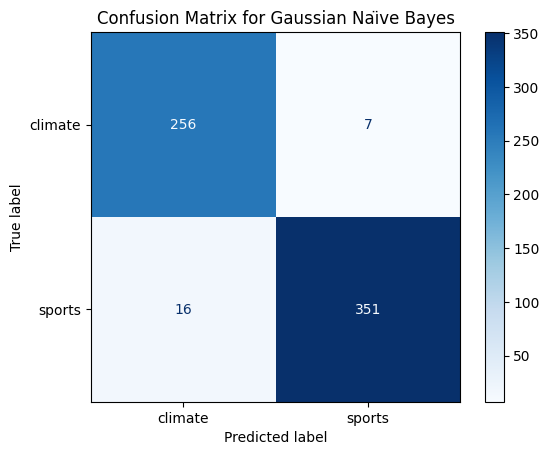

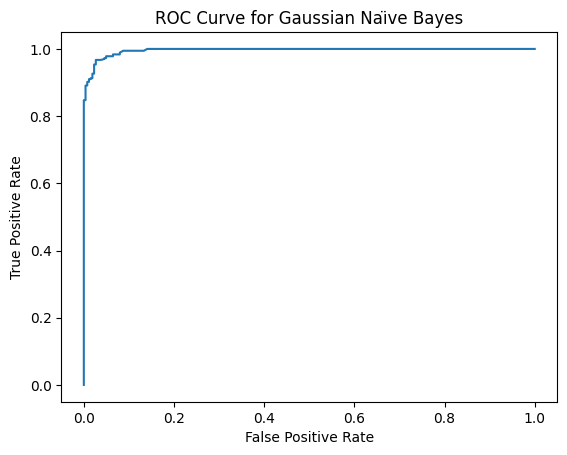

In [30]:
nb = GaussianNB()
nb.fit(X=train_lsi, y=train.root_label)
pred_y = nb.predict(test_lsi)
true_y = test.root_label.values

# Metrics
print_metrics(true_y, pred_y, pos_label, average='binary')
# for some reason it gets the labels the wrong way around?
plot_confusion_matrix(svm, test_lsi, true_y, list(reversed(binary_classes)),
                      f'Confusion Matrix for Gaussian Naı̈ve Bayes')
plot_roc(svm, true_y, pos_label, f'ROC Curve for Gaussian Naı̈ve Bayes')

# Question 8

In [31]:
# Pipeline setup
cache_dir = 'q8_pipeline_cache'
pipe = Pipeline(steps=[('preprocessor', None),
                       ('feature_extraction', TfidfVectorizer(stop_words='english')),
                       ('dimensionality_reduction', None),
                       ('classifier', None)], memory=cache_dir)

lsi_variants = [TruncatedSVD(n_components=k, random_state=seed) for k in [5, 30, 80]]
nmf_variants = [NMF(n_components=k, init='random', random_state=seed, max_iter=500) for k in [5, 30, 80]]

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'preprocessor': [FunctionTransformer(lemmatize_corpus), FunctionTransformer(stem_corpus)],
    'feature_extraction__min_df': [3, 5],
    'dimensionality_reduction': lsi_variants + nmf_variants,
    'classifier': [LinearSVC(random_state=seed, max_iter=10000, C=10),
                   LogisticRegression(penalty=None, random_state=seed, max_iter=10000, solver='saga'),
                   LogisticRegression(penalty='l1', C=10, random_state=seed, max_iter=10000, solver='saga'),
                   LogisticRegression(penalty='l2', C=100, random_state=seed, max_iter=10000, solver='saga'),
                   GaussianNB()
                   ]
}

def run_train():
    search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=8, scoring='accuracy', verbose=1)
    search_result = search.fit(train['full_text'], train.root_label)
    return search, search_result
search, search_result = filter_parallel_warnings(run_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


In [32]:
# Get top configuration and fit against training data
top_no = 5
rankings = search_result.cv_results_['rank_test_score']
top_indices = np.argsort(rankings)[:top_no]
top_params = [search_result.cv_results_['params'][i] for i in top_indices]
top_mean_validation_accuracies = [search_result.cv_results_['mean_test_score'][i] for i in top_indices]
top_pipes = []
top_predictions = []
for idx, param in enumerate(top_params):
    print(f'Fitting pipe {idx + 1}')
    pipe = Pipeline(steps=[('preprocessor', param['preprocessor']),
                           ('feature_extraction',
                            TfidfVectorizer(stop_words='english', min_df=param['feature_extraction__min_df'])),
                           ('dimensionality_reduction', param['dimensionality_reduction']),
                           ('classifier', param['classifier'])])
    # Note: this should just work nicely with pipe.fit(), but for some reason the feature_extraction and dimensionality_reduction steps will only work properly with fit_transform()
    out = pipe[:3].fit_transform(train['full_text'])
    out = pipe[3].fit(out, train.root_label)
    pred_y = pipe.predict(test['full_text'])
    top_predictions.append(pred_y)

Fitting pipe 1
Fitting pipe 2
Fitting pipe 3
Fitting pipe 4
Fitting pipe 5


In [33]:
# Get test data performance
for idx, pred_y in enumerate(top_predictions):
    true_y = test.root_label.values
    print(f'\n==Top pipe # {idx + 1} performance==')
    print('Configuration:')
    print(top_params[idx])
    print(f'Validation Accuracy: {top_mean_validation_accuracies[idx]}')
    print(f'Test metrics:')
    print_metrics(true_y, pred_y, pos_label, average='binary')


==Top pipe # 1 performance==
Configuration:
{'classifier': LogisticRegression(max_iter=10000, penalty=None, random_state=42, solver='saga'), 'dimensionality_reduction': TruncatedSVD(n_components=80, random_state=42), 'feature_extraction__min_df': 5, 'preprocessor': FunctionTransformer(func=<function lemmatize_corpus at 0x7f52f9bc9430>)}
Validation Accuracy: 0.959126984126984
Test metrics:
Accuracy: 0.9682539682539683
Recall: 0.9591280653950953
Precision: 0.9859943977591037
F-1 score: 0.9723756906077348

==Top pipe # 2 performance==
Configuration:
{'classifier': LinearSVC(C=10, max_iter=10000, random_state=42), 'dimensionality_reduction': TruncatedSVD(n_components=80, random_state=42), 'feature_extraction__min_df': 5, 'preprocessor': FunctionTransformer(func=<function lemmatize_corpus at 0x7f52f9bc9430>)}
Validation Accuracy: 0.9583333333333334
Test metrics:
Accuracy: 0.9682539682539683
Recall: 0.9591280653950953
Precision: 0.9859943977591037
F-1 score: 0.9723756906077348

==Top pipe #

# Question 9

In [34]:
# Reviewing data
name = 'leaf_label'
leaf_label_counts = train[name].value_counts()
multiclass_names = list(leaf_label_counts.keys())
print(f'Leaf labels split:\n {leaf_label_counts}')

Leaf labels split:
 earthquake     291
football       289
forest fire    288
drought        282
soccer         282
chess          279
flood          276
cricket        269
hockey         264
Name: leaf_label, dtype: int64


## Training & Confusion Matrix
#### How did you resolve the class imbalance issue in the One VS the rest model?
The class imbalance is resolved by upsampling minority classes. The particular upsampling method is random sampling with replacement, meaning there will be duplicate documents. This is not as sophisticated as interpolation, noise or NLP-specific methods like backtranslation, but it is very cheap to run.

In [35]:
# The sampler here should upsample minority classes whenever the pipeline is called.
# It works with random sampling with replacement. There are much more advanced samplers, but this one is very fast.
def train_multi_class(sampler, leaf_label):
    predictions = []
    estimators = []
    titles = ['One vs. Rest - Naive Bayes', 'One vs. Rest - Linear SVM', 'One vs. One - Naive Bayes',
              'One vs. One - Linear SVM']

    for multiclass_method in [OneVsRestClassifier, OneVsOneClassifier]:
        for classifier in [GaussianNB, LinearSVC]:
            pipe = ImPipeline([('sampler', sampler),
                               ('dimensionality_reduction', TruncatedSVD(n_components=80, random_state=seed)),
                               ('classifier', classifier())])

            estimator = multiclass_method(pipe, n_jobs=8)
            # To save some effort we'll start off with the data after the TF-IDF step. Arguably this is not the same as if we did TF-IDF on the upsampled documents.
            # In the upsampled case, basically all words in the minority class would exceed the min_df threshold. But we'll ignore this for our case.
            estimator.fit(train_tf_idf, leaf_label)
            estimators.append(estimator)
            predictions.append(estimator.predict(test_tf_idf))
    return predictions, estimators, titles

In [36]:
def run_train():
    return train_multi_class(RandomOverSampler(random_state=seed), train.leaf_label)
train_result = filter_parallel_warnings(run_train)

In [37]:
# Display Results
def print_results(train_result, leaf_label, labels):
    for p, e, t in zip(*train_result):
        print(f'\n=={t}==')
        print_metrics(leaf_label, p, average='weighted')
        disp = ConfusionMatrixDisplay.from_estimator(
            e,
            test_tf_idf,
            leaf_label,
            labels=labels,
            xticks_rotation='vertical',
            # display_labels=classes, # for some reason it gets the labels the wrong way around?
            cmap=plt.cm.Blues,
        )
        disp.ax_.set_title(t)
        plt.show()


==One vs. Rest - Naive Bayes==
Accuracy: 0.6777777777777778
Recall: 0.6777777777777778
Precision: 0.7036418746311466
F-1 score: 0.6848444040216004


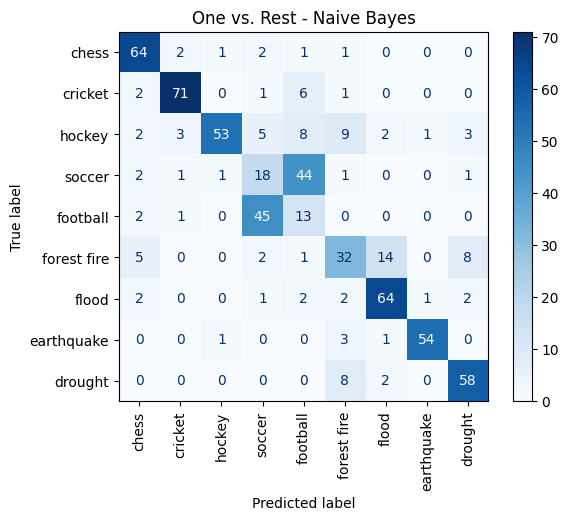


==One vs. Rest - Linear SVM==
Accuracy: 0.8063492063492064
Recall: 0.8063492063492064
Precision: 0.8127128930030012
F-1 score: 0.8060300762987817


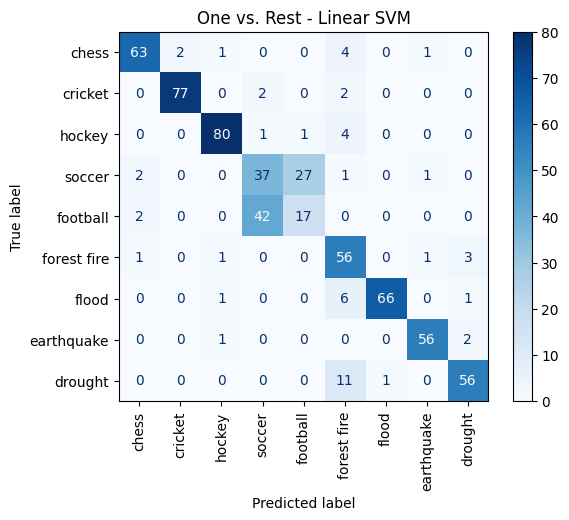


==One vs. One - Naive Bayes==
Accuracy: 0.6730158730158731
Recall: 0.6730158730158731
Precision: 0.7320943824720002
F-1 score: 0.6706105275825801


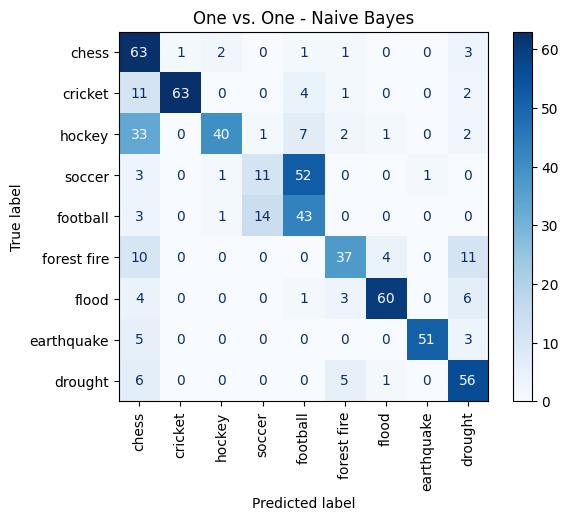


==One vs. One - Linear SVM==
Accuracy: 0.8
Recall: 0.8
Precision: 0.814416581901731
F-1 score: 0.8025766023874948


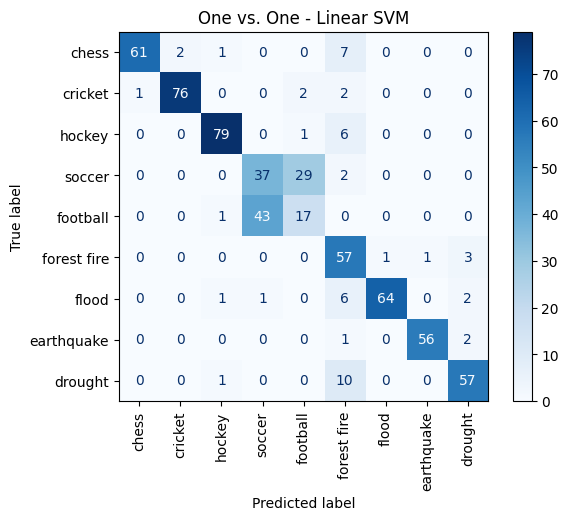

In [38]:
custom_names = ['chess', 'cricket', 'hockey', 'soccer', 'football', 'forest fire', 'flood', 'earthquake', 'drought']
print_results(train_result, test.leaf_label, custom_names)

#### Do you observe any structure in the confusion matrix?
There are a few things to observe. Firstly, there is a pretty large performance discrepancy between the Naive Bayes models and SVM for both multiclass types. Naive Bayes performs significantly worse and struggles with correctly classifying "forest fires" and "hockey". A pattern that all models share is difficulty discriminating between "football" and "soccer". This is likely due to these names referring different sports around the world (e.g "football" in Europe is a sport of kicking the ball, whereas in "football" in the US refers to a ball-based contact sport).

## Merging Football and Soccer

In [39]:
train_merged = train.copy(deep=True)
train_merged['leaf_label'] = train_merged['leaf_label'].replace(['football', 'soccer'], 'foccer')
test_merged = test.copy(deep=True)
test_merged['leaf_label'] = test_merged['leaf_label'].replace(['football', 'soccer'], 'foccer')
leaf_label_counts = train_merged[name].value_counts()
print(f'Leaf labels split:\n {leaf_label_counts}')

Leaf labels split:
 foccer         571
earthquake     291
forest fire    288
drought        282
chess          279
flood          276
cricket        269
hockey         264
Name: leaf_label, dtype: int64


In [40]:
sampler_args = {'foccer_count': leaf_label_counts.to_dict()['foccer']}
# NOTE: the custom resampler function is in the helper file in order to make pickle.py happy.

def run_train():
    return train_multi_class(FunctionSampler(func=resample_and_merge, kw_args=sampler_args),
                                 train_merged['leaf_label'])
train_result = filter_parallel_warnings(run_train)


==One vs. Rest - Naive Bayes==
Accuracy: 0.807936507936508
Recall: 0.807936507936508
Precision: 0.811637439597468
F-1 score: 0.8050292211545332


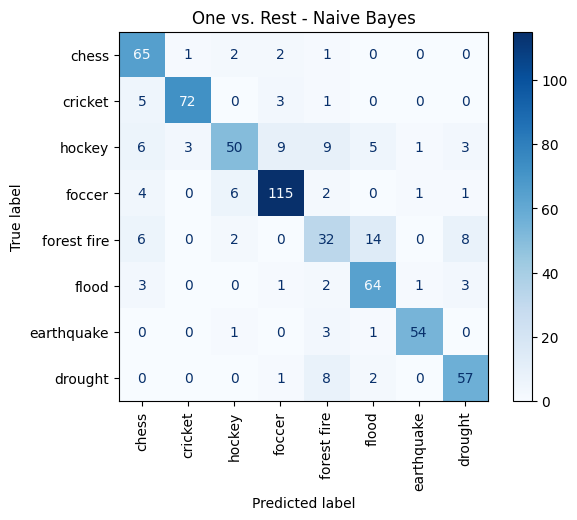


==One vs. Rest - Linear SVM==
Accuracy: 0.919047619047619
Recall: 0.919047619047619
Precision: 0.9294133190579195
F-1 score: 0.9215292365685929


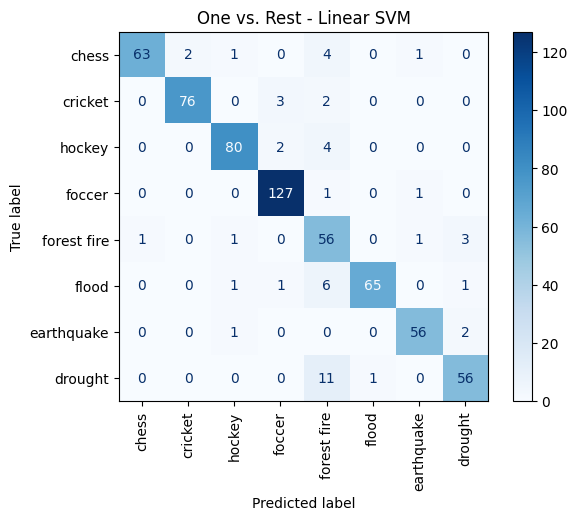


==One vs. One - Naive Bayes==
Accuracy: 0.7777777777777778
Recall: 0.7777777777777778
Precision: 0.8364326268863492
F-1 score: 0.7900003388610535


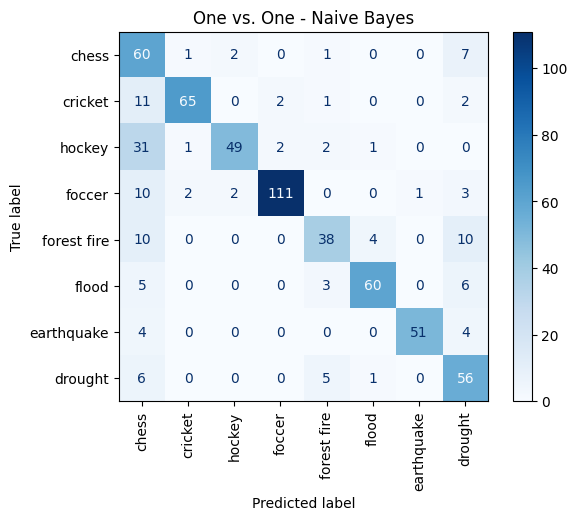


==One vs. One - Linear SVM==
Accuracy: 0.9158730158730158
Recall: 0.9158730158730158
Precision: 0.9316139023000554
F-1 score: 0.9198389911256561


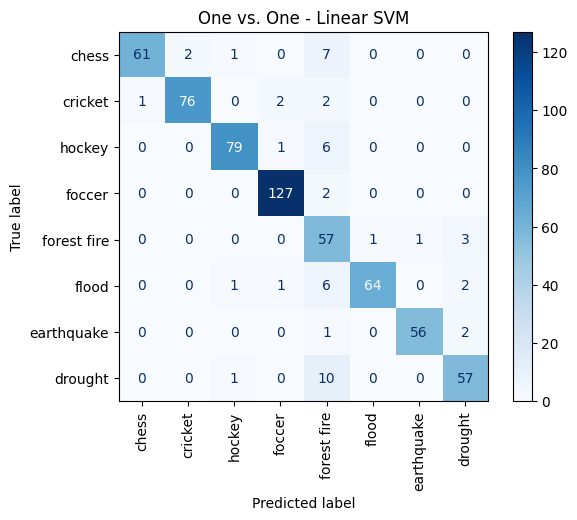

In [41]:
# Display Results
custom_names = ['chess', 'cricket', 'hockey', 'foccer', 'forest fire', 'flood', 'earthquake', 'drought']
print_results(train_result, test_merged.leaf_label, custom_names)

#### How did the accuracy change in One VS One and One VS the rest?
It appears to have improved by 10% across all models, which makes sense as it was the cause of the most confusion for the model.

## Balancing Football and Soccer

In [42]:
train_result = train_multi_class(RandomOverSampler(random_state=seed), train_merged.leaf_label)


==One vs. Rest - Naive Bayes==
Accuracy: 0.8126984126984127
Recall: 0.8126984126984127
Precision: 0.8152478095096225
F-1 score: 0.8101670310691936


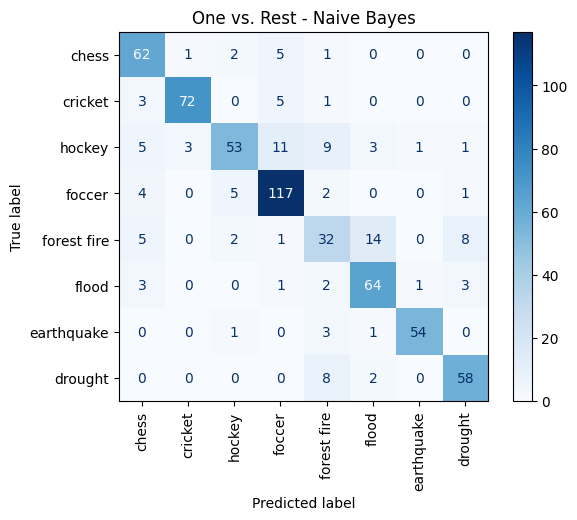


==One vs. Rest - Linear SVM==
Accuracy: 0.9206349206349206
Recall: 0.9206349206349206
Precision: 0.930936295885455
F-1 score: 0.9231287586616349


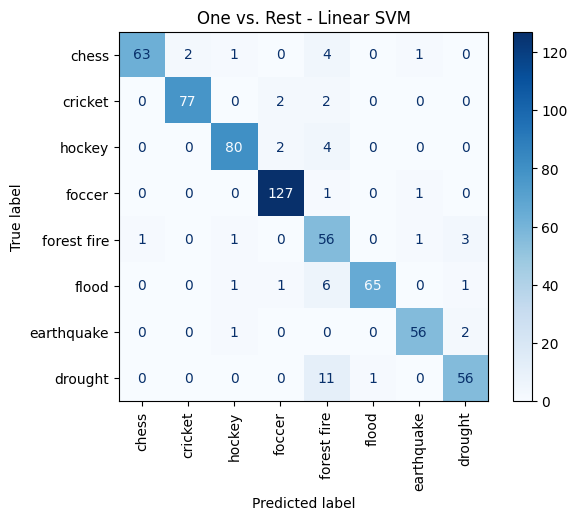


==One vs. One - Naive Bayes==
Accuracy: 0.6476190476190476
Recall: 0.6476190476190476
Precision: 0.7495382392226856
F-1 score: 0.6516786474322658


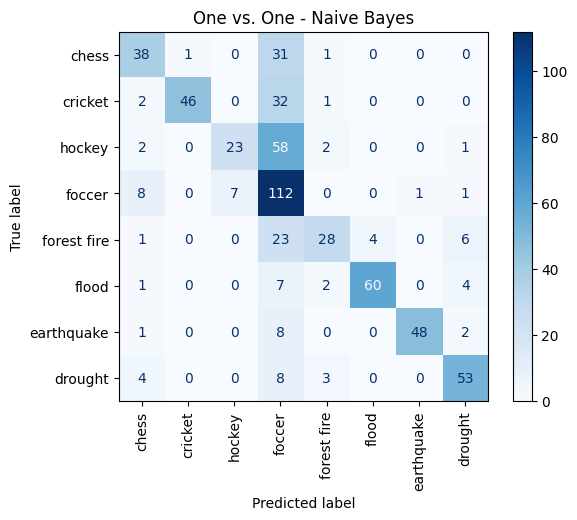


==One vs. One - Linear SVM==
Accuracy: 0.9126984126984127
Recall: 0.9126984126984127
Precision: 0.9284235170599935
F-1 score: 0.9166546716077345


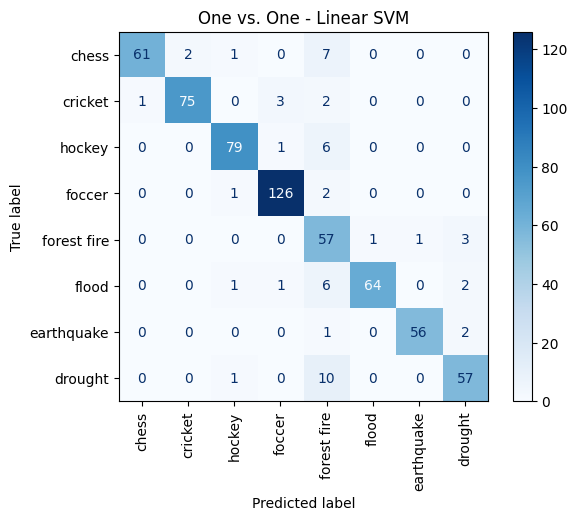

In [43]:
custom_names = ['chess', 'cricket', 'hockey', 'foccer', 'forest fire', 'flood', 'earthquake', 'drought']
print_results(train_result, test_merged.leaf_label, custom_names)

#### Does class imbalance impact the performance of the classification once some classes are merged?
Yes, it seems that after applying the balancing via random oversampling to the merged classes as well the model accuracy increased by a further 1-2%. The only exception here appears to be the One vs. One Naive Bayes case, where the accuracy degrades. It's not really clear why this is, especially as all the other training logic is shared between so a bug is unlikely.

# Question 10

#### Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than the probabilities themselves?

Compared to the raw co-occurrence probabilities, the ratio is better able to distinguish relevant words from irrelevant words and it is also better able to discriminate between the two relevant words. This is because the ratio will be larger if a pair of words appears together often than the pair appears independently.

#### Would GLoVE embeddings return the same vector for the word "running" in both cases?
Yes, because even though GLoVE is trained contextually on entire texts, the final embeddings are per-word. This means that only one corresponding embedding can be looked up for "running", regardless of surrounding words.

#### What do you expect for the values of?
It would be expected that  $\texttt{GLoVE["queen"]} - \texttt{GLoVE["king"]} \approx \texttt{GLoVE["wife"]} - \texttt{GLoVE["husband"]}$ as both embedding pairs describe a heterosexual, spousal relationship, so after removing the "royalty" in the first case and "regularity" (maybe?) in the second, the embeddings should be similar. It follows that the L2 norms of the above expressions should also be similar. When we apply this to the combined expression, we get $\| \texttt{GLoVE["queen"]} - \texttt{GLoVE["king"]} - \texttt{GLoVE["wife"]} + \texttt{GLoVE["husband"]} \|_2 \approx \|\textbf{0} \|_2 = 0$.

#### Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding?
Preferably lemmatize as stemming does not always create a well-formed real word so it might become difficult to match the right GLoVE embedding.

# Question 11

In [44]:
embeddings_dict = {}
dimension_of_glove = 300
# Downloaded from https://nlp.stanford.edu/projects/glove/
with open("glove.6B/glove.6B.300d.txt", 'r') as f:  # if 'r' fails with unicode error, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

## Describe a feature engineering process that uses GLoVE word embeddings to represent each document
We can engineer features from a corpus by doing the following:
 1. Cleaning and lemmatising each of the $N$ documents in the corpus.
 2. For each document, split up the document into $n$ tokens and filter out all stop words.
 3. Get the GLoVE embedding $\textbf{g}\in \mathbb{R}^d$ of dimensionality $d$ for each token $j$ (skip words without an embedding).
 4. Calculate the mean across the $d$ axis: $\mu_i = \frac{1}{n} \sum_{j=1}^n g_{ji}$, which yields us a mean vector $\textbf{\mu}\in \mathbb{R}^d$ for the entire document.
 5. As each mean has the same dimension we will have the following feature matrix $\textbf{X}\in \mathbb{R}^{N\times d}$.

## Implementation

In [45]:
stops = set(stopwords.words('english'))
def glove_avg(text: str, glove_dict: Dict[str, np.ndarray], stop_words: List[str] = []) -> np.ndarray:
    tokens = nltk.word_tokenize(text)
    embedded = [glove_dict[t] for t in tokens if t not in stop_words and t in glove_dict]
    aggregated = np.vstack(embedded).mean(axis=0)
    return aggregated


def glove_corpus_avg(X: np.ndarray, glove_dict: Dict[str, np.ndarray], stop_words: List[str] = []):
    X_transformed = np.vstack([glove_avg(x, glove_dict, stop_words) for x in X])
    return X_transformed

In [46]:
train_embedded = glove_corpus_avg(train_lemmatized, embeddings_dict, stops)
test_embedded = glove_corpus_avg(test_lemmatized, embeddings_dict, stops)

param_grid = {
    'C': 10 ** np.arange(-2, 5, dtype=float)
}

model = LinearSVC(random_state=seed, max_iter=10000)
def run_train():
    search = GridSearchCV(model, param_grid, cv=5, n_jobs=8, scoring='accuracy', verbose=1)
    search_result = search.fit(train_embedded, train.root_label)
    return search, search_result
search, search_result = filter_parallel_warnings(run_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


Best config {'C': 1.0}
Accuracy: 0.9634920634920635
Recall: 0.9591280653950953
Precision: 0.9777777777777777
F-1 score: 0.968363136176066


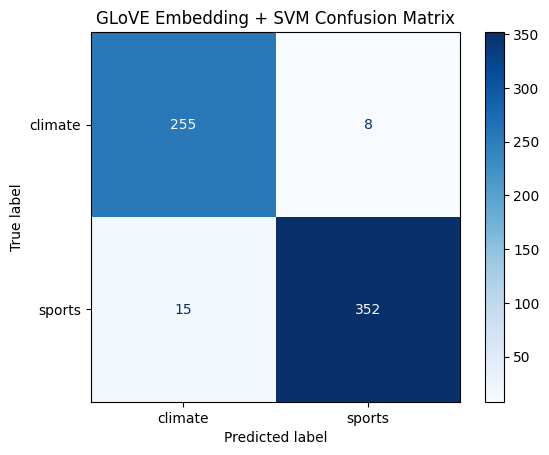

In [47]:
best_model = search_result.best_estimator_
best_params = search_result.best_params_
pred_y = best_model.predict(test_embedded)
binary_classes = list(root_label_counts.keys())
pos_label = binary_classes[0]
print(f'Best config {best_params}')
print_metrics(test.root_label, pred_y, pos_label, average='binary')
plot_confusion_matrix(best_model, test_embedded, test.root_label, classes=list(reversed(binary_classes)), title='GLoVE Embedding + SVM Confusion Matrix')

# Question 12 - Embedding size vs. Test Accuracy

In [48]:
paths = ['glove.6B.50d.txt','glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt']
sizes = []
accuracies = []
for p in paths:
    embeddings_dict = {}
    with open(f"glove.6B/{p}", 'r') as f:  # if 'r' fails with unicode error, please use 'rb'
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    embed_size = next(iter(embeddings_dict.values())).size
    sizes.append(embed_size)
    train_embedded = glove_corpus_avg(train_lemmatized, embeddings_dict, stops)
    test_embedded = glove_corpus_avg(test_lemmatized, embeddings_dict, stops)
    model = LinearSVC(random_state=seed, max_iter=10000, **best_params)
    model.fit(train_embedded, train.root_label)
    accuracy = model.score(test_embedded,test.root_label)
    accuracies.append(accuracy)

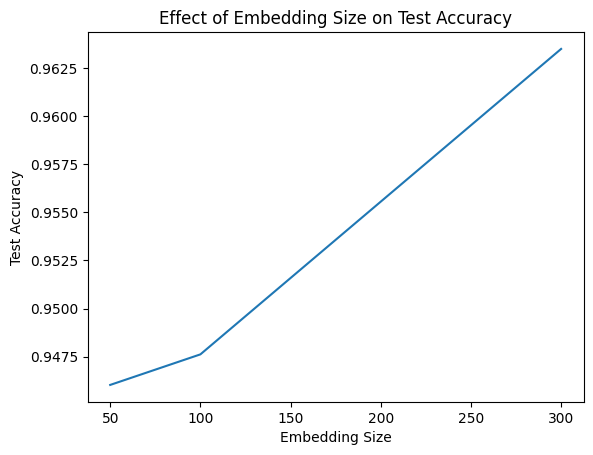

In [49]:
plt.figure()
plt.plot(sizes, accuracies)
plt.title('Effect of Embedding Size on Test Accuracy')
plt.xlabel('Embedding Size')
plt.ylabel('Test Accuracy')
plt.show()

#### Is this trend expected?
Generally it makes sense that a larger embedding will yield a better accuracy as the representation of a word becomes more detailed. Additionally, the SVM also has more weights to optimise (e.g 50 vs. 300) which also allows for a higher dimensional boundary.

# Question 13

Text(0.5, 1.0, '2D Projection of Train GLoVE Embeddings')

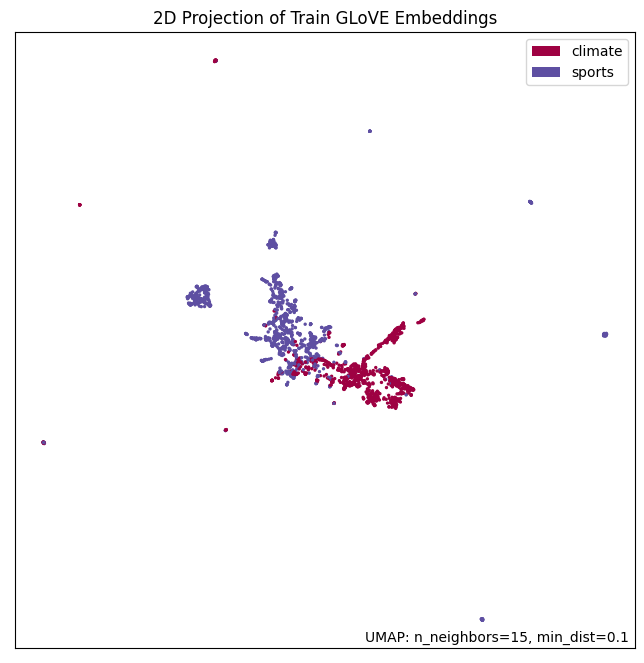

In [50]:
glove_mapper = UMAP().fit(train_embedded)
umap.plot.points(glove_mapper, labels=train.root_label)
plt.title('2D Projection of Train GLoVE Embeddings')

Text(0.5, 1.0, '2D Projection of Noise ')

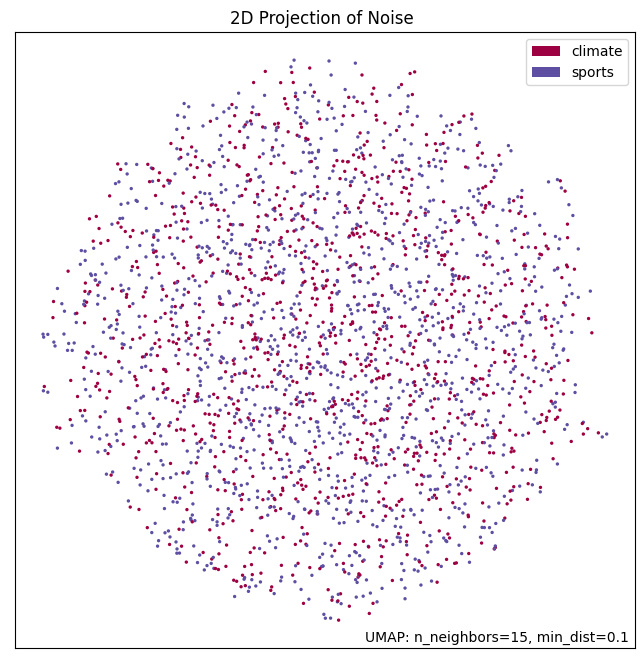

In [51]:
random_vecs = normalize(np.random.rand(*train_embedded.shape))
random_mapper = UMAP().fit(random_vecs)
umap.plot.points(random_mapper, labels=train.root_label)
plt.title('2D Projection of Noise ')

#### Are there clusters formed in either or both of the plots?
We can see from the above that the GLoVE embeddings of a particular class tend to cluster with other embeddings of the same class. However, there is some overlap at the edges of the main "climate" and "sports" clusters, which is likely where a model would try to fit a decision boundary. By comparison random vectors show unclustered noise, which makes sense if they are generated uniformly.